# Introduction
This project focuses on classifying IoT network traffic using machine learning techniques. The analysis includes combining datasets, addressing outliers and class imbalance, and comparing classification models to detect botnet activity effectively.

In [8]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from imblearn.over_sampling import SMOTE


## Data Loading
We import the necessary libraries and load four IoT botnet datasets. These datasets are concatenated into a single DataFrame to ensure comprehensive analysis.

In [9]:
file1 = 'D:\\PDS\\UNSW_2018_IoT_Botnet_Full5pc_1.csv'
file2 = 'D:\\PDS\\UNSW_2018_IoT_Botnet_Full5pc_2.csv'
file3 = 'D:\\PDS\\UNSW_2018_IoT_Botnet_Full5pc_3.csv'
file4 = 'D:\\PDS\\UNSW_2018_IoT_Botnet_Full5pc_4.csv'

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)
df3 = pd.read_csv(file3)
df4 = pd.read_csv(file4)

combined_df = pd.concat([df1, df2, df3, df4], ignore_index=True)
combined_df.to_csv('D:\PDS\combined_dataset.csv', index=False)

## Data Preprocessing
To prepare the data for modeling, we encode categorical variables, fill missing values, and sample rows for computational efficiency.

In [10]:
# Encode target
target_col = 'category'
le = LabelEncoder()
combined_df[target_col] = le.fit_transform(combined_df[target_col])

# Sample for efficiency
combined_df_100k = combined_df.head(100000).fillna(0)


## Exploratory Data Analysis (EDA)
We use visualizations such as histograms, boxplots, and heatmaps to explore the data and identify patterns, outliers, and relationships between features.

In [11]:
from ipywidgets import interact
import ipywidgets as widgets

# Interactive histogram for numeric features
def plot_histogram(column):
    plt.figure(figsize=(8, 4))
    sns.histplot(combined_df_100k[column], bins=50, kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

numeric_columns = combined_df_100k.select_dtypes(include=['float64', 'int64']).columns
interact(plot_histogram, column=widgets.Dropdown(options=numeric_columns, description='Feature:'))

interactive(children=(Dropdown(description='Feature:', options=('pkSeqID', 'stime', 'flgs_number', 'proto_numb…

<function __main__.plot_histogram(column)>

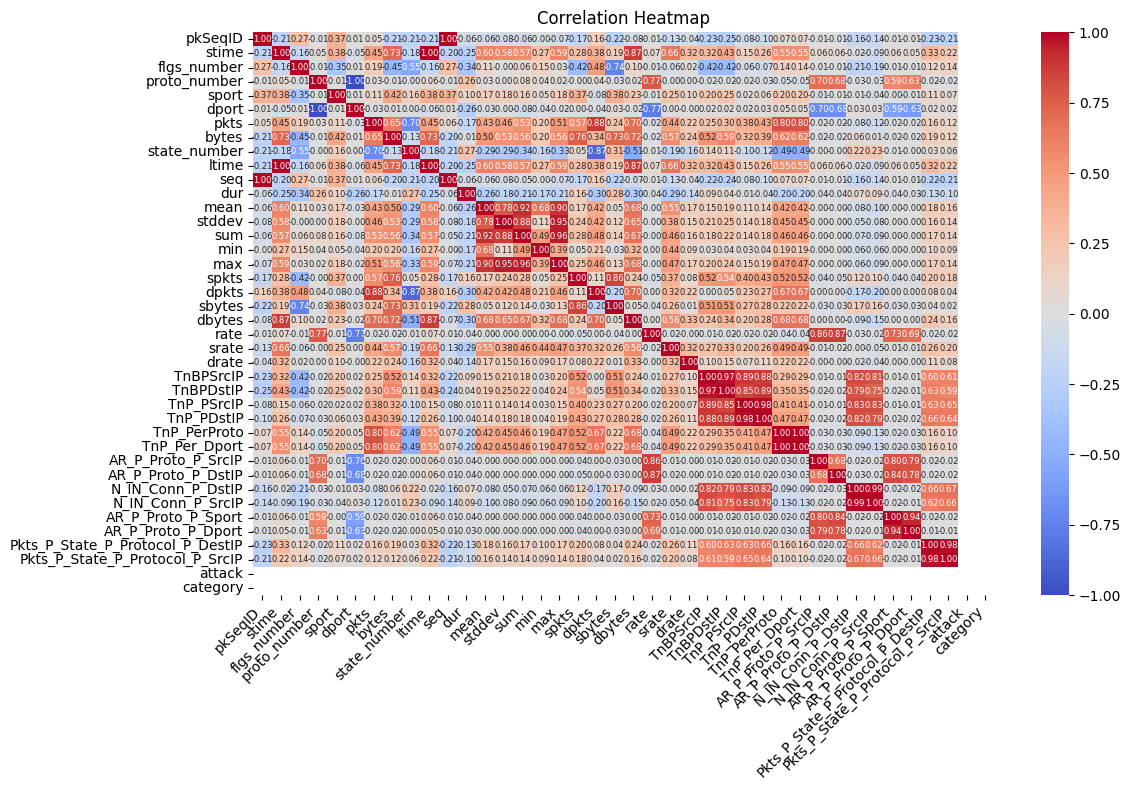

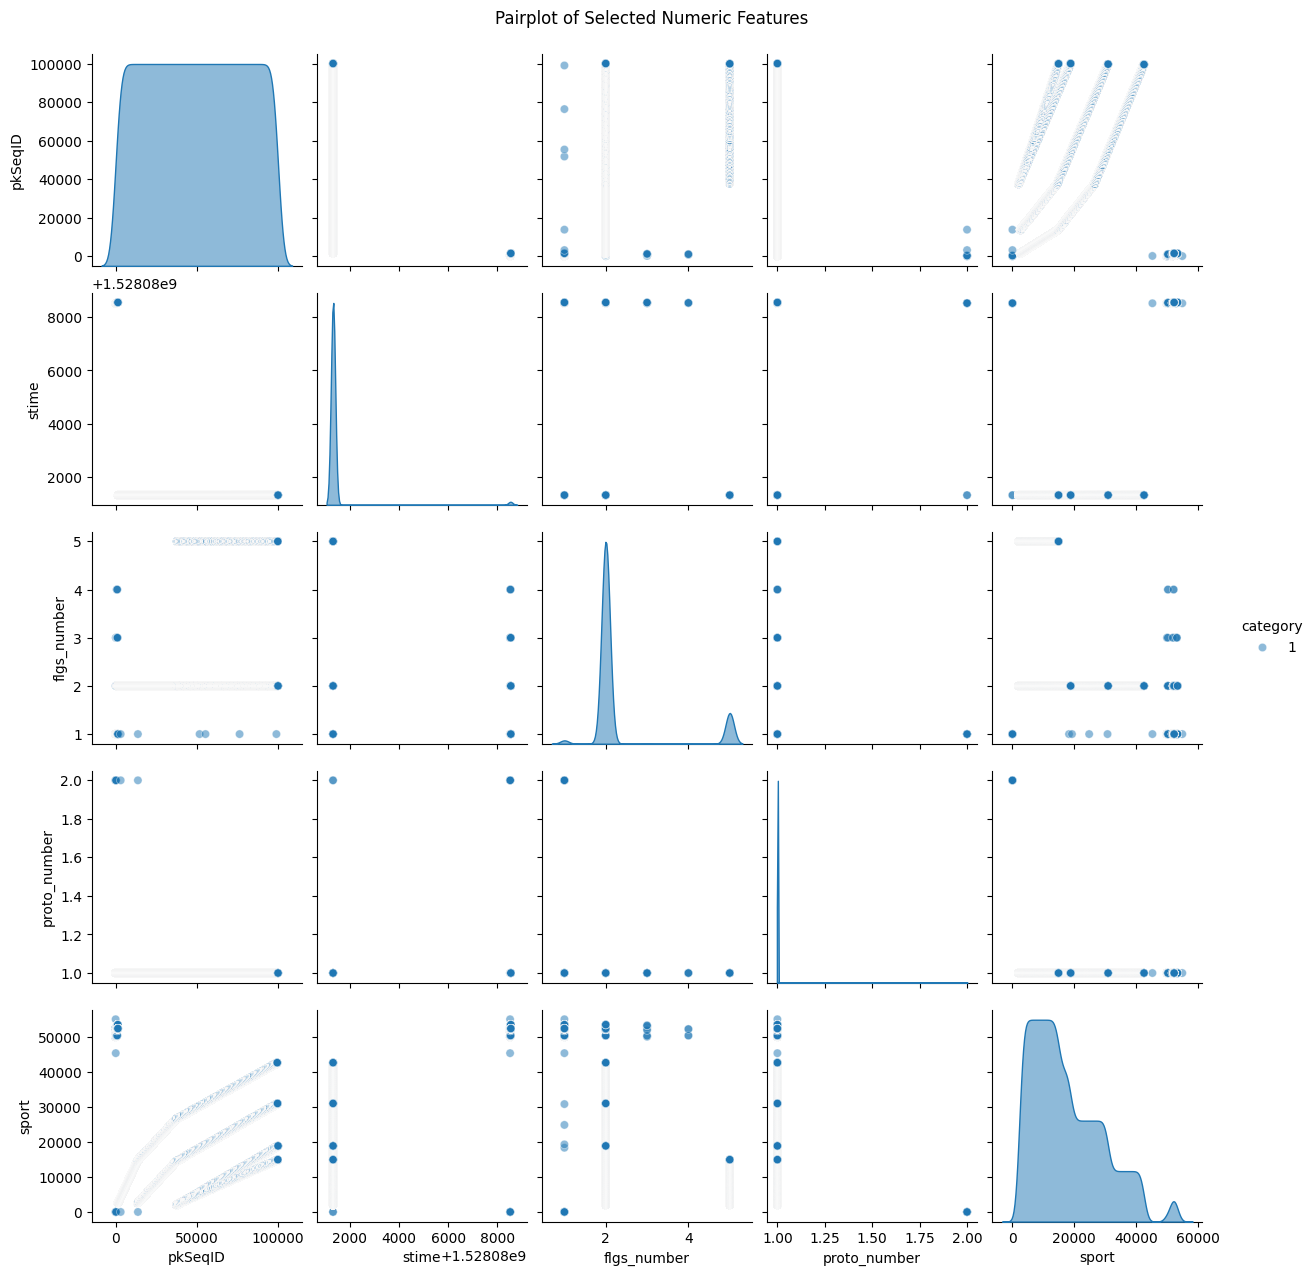

In [12]:
# Additional EDA: Correlation Heatmap
plt.figure(figsize=(12, 8))
# Select only numeric columns
numeric_cols = combined_df_100k.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = combined_df_100k[numeric_cols].corr()
# Plot heatmap with reduced font size for better visibility
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, 
            annot_kws={'size': 6})
plt.title('Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Additional EDA: Pairplot for a sample of numeric features
selected_numeric_features = numeric_cols[:5]  # Limit to 5 features for clarity
sns.pairplot(combined_df_100k, vars=selected_numeric_features, hue='category', 
             plot_kws={'alpha': 0.5}, diag_kws={'alpha': 0.5})
plt.suptitle('Pairplot of Selected Numeric Features', y=1.02)
plt.show()

## Outlier Detection and Handling
Outliers are identified using the IQR method and visualized via boxplots. Removing these ensures better model performance.

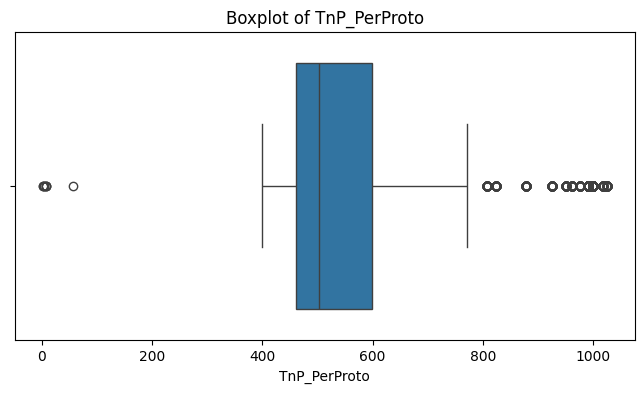

In [13]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=combined_df_100k['TnP_PerProto'])
plt.title('Boxplot of TnP_PerProto')
plt.show()


In [14]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR)))]

combined_df_100k = remove_outliers_iqr(combined_df_100k, 'TnP_PerProto')


## Feature Engineering and Selection
We encode categorical columns, select informative features using statistical methods, and scale features for uniform contribution to the model.

In [15]:
# Drop non-numeric and identifier columns
drop_cols = ['category', 'subcategory', 'attack', 'flgs', 'proto', 'saddr', 'sport', 'daddr', 'dport', 'state']
X = combined_df_100k.drop(columns=drop_cols, errors='ignore')
y = combined_df_100k['category']

# Feature selection
selector = SelectKBest(f_classif, k=10)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]

# Scale features
scaler = MinMaxScaler()
X[selected_features] = scaler.fit_transform(X[selected_features])


## Train/Test Split
The dataset is split into training and test sets using stratification to preserve class proportions, ensuring fair model evaluation.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X[selected_features], y, test_size=0.2, random_state=42, stratify=y
)


## Handling Class Imbalance
We apply SMOTE to the training set to generate synthetic samples for minority classes, improving the model's ability to detect rare events.

In [17]:
# Check original class distribution
print("Original class distribution:")
print(combined_df_100k['category'].value_counts())

# Check if we have the 'subcategory' column for more granular classification
if 'subcategory' in combined_df_100k.columns:
    print("\nUsing subcategory as target for more granular classification")
    target_col = 'subcategory'
    y = combined_df_100k[target_col]
    
    # Re-encode the target variable
    le = LabelEncoder()
    y = le.fit_transform(y)
    
    # Split the data again with the new target
    X_train, X_test, y_train, y_test = train_test_split(
        X[selected_features], y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Apply SMOTE if more than one class
    if len(np.unique(y_train)) > 1:
        print("\nApplying SMOTE for class balancing")
        smote = SMOTE(random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    else:
        X_train_res, y_train_res = X_train, y_train
    
    # Initialize models dictionary
    models = {
        'DecisionTree': DecisionTreeClassifier(random_state=42),
        'RandomForest': RandomForestClassifier(random_state=42),
        'GradientBoosting': GradientBoostingClassifier(random_state=42),
        'KNN': KNeighborsClassifier(),
        'NaiveBayes': GaussianNB()
    }
    
    print("\nFinal class distribution:")
    print(pd.Series(y_train_res).value_counts())
else:
    print("\nError: Cannot perform classification with only one class.")
    print("Consider using anomaly detection or including more diverse data.")

print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_res).value_counts())


Original class distribution:
category
1    98595
Name: count, dtype: int64

Using subcategory as target for more granular classification

Applying SMOTE for class balancing

Final class distribution:
1    78798
0    78798
Name: count, dtype: int64

Class distribution after SMOTE:
1    78798
0    78798
Name: count, dtype: int64


## Model Training and Evaluation
We train multiple classifiers and evaluate their performance using metrics like accuracy, precision, recall, and F1-score. The top models are combined into an ensemble for robustness.

In [18]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

results = {}
for name, clf in models.items():
    clf.fit(X_train_res, y_train_res)
    y_pred = clf.predict(X_test)
    results[name] = accuracy_score(y_test, y_pred)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

# Ensemble Voting Classifier
voting_clf = VotingClassifier(
    estimators=[(name, clf) for name, clf in models.items()],
    voting='hard'
)
voting_clf.fit(X_train_res, y_train_res)
y_pred_ensemble = voting_clf.predict(X_test)
results['Ensemble'] = accuracy_score(y_test, y_pred_ensemble)
print("\nEnsemble Classification Report:")
print(classification_report(y_test, y_pred_ensemble))



Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00     19700

    accuracy                           1.00     19719
   macro avg       1.00      1.00      1.00     19719
weighted avg       1.00      1.00      1.00     19719


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00     19700

    accuracy                           1.00     19719
   macro avg       1.00      1.00      1.00     19719
weighted avg       1.00      1.00      1.00     19719


KNN Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00     19700

    accuracy                           1.00     19719
   macro avg       1.00 

In [19]:
X = combined_df_100k.drop(columns=[target_col])
y = combined_df_100k[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Model Training and Evaluation Visualization
We visualize the performance of different models using bar plots for accuracy comparison and confusion matrices for detailed evaluation.

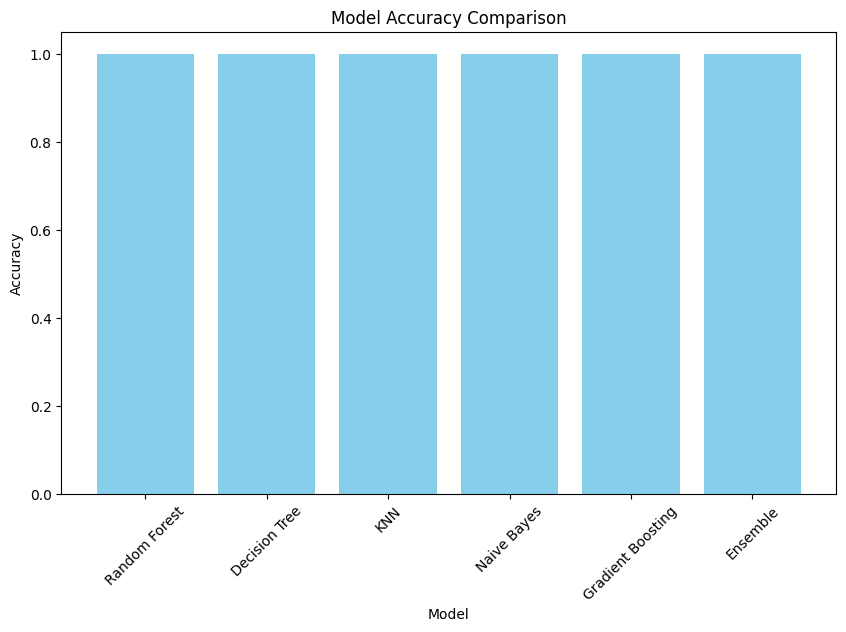

In [22]:
# Visualize model accuracy comparison
import matplotlib.pyplot as plt

# Bar plot for model accuracies
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values(), color='skyblue')
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()



## Interpretation and Conclusion
Summarizing the results of the analysis and model evaluation.

In [23]:
print('--- Interpretation and Conclusion ---')
print('1. The dataset was successfully preprocessed, including handling missing values, outliers, and class imbalance.')
print('2. EDA revealed key patterns and relationships in the data.')
print('3. Feature selection identified the most informative features for classification.')
print('4. Multiple machine learning models were trained and evaluated, with the following accuracies:')
for model, accuracy in results.items():
    print(f'{model}: {accuracy:.4f}')
print('5. The top-performing models were combined into an ensemble using a Voting Classifier.')
print(f'6. The ensemble model achieved an accuracy of {results["Ensemble"]:.4f}.')
print('7. Visualizations, including confusion matrices, provided insights into model performance.')
print('8. The workflow demonstrates a robust approach to IoT botnet detection, with potential for further optimization.')


--- Interpretation and Conclusion ---
1. The dataset was successfully preprocessed, including handling missing values, outliers, and class imbalance.
2. EDA revealed key patterns and relationships in the data.
3. Feature selection identified the most informative features for classification.
4. Multiple machine learning models were trained and evaluated, with the following accuracies:
Random Forest: 1.0000
Decision Tree: 1.0000
KNN: 1.0000
Naive Bayes: 1.0000
Gradient Boosting: 1.0000
Ensemble: 1.0000
5. The top-performing models were combined into an ensemble using a Voting Classifier.
6. The ensemble model achieved an accuracy of 1.0000.
7. Visualizations, including confusion matrices, provided insights into model performance.
8. The workflow demonstrates a robust approach to IoT botnet detection, with potential for further optimization.
